# Training a quanutm battery via QNN

We have two registers of qubits: a ''charging'' register and a ''battery'' register. Our aim is to design parameterized quantum circuit that transfers energy from the charging qubits to the battery qubits.

In [1]:
# Imports
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt
import TheWalrus as tw
from IPython.core.debugger import set_trace

from math import pi
import time

ModuleNotFoundError: No module named 'TheWalrus'

In [4]:
# How to define and simulate a QNN
N_charge = 2
N_battery = 8

N_qubits = N_charge + N_battery

charge_qubits = [_ for _ in range(N_charge)]
battery_qubits = [_ for _ in range(N_charge,N_qubits)]

# Define PennyLane 'device'
# 'lightning.qubit' is a slightly faster kind of qubit simulation
dev = qml.device('lightning.qubit', wires=N_qubits)

In [3]:
charge_qubits

[0, 1]

In [5]:
# Define number of layers
N_layers = 1

# Get shape of the parameters as (N_layers, params per layer)
param_shape = (N_layers, N_charge, 3*(1 + N_battery))
params = np.random.normal(scale=0.1, size=param_shape, requires_grad=True)

In [6]:
# 'adjoint' diff_method is a fast, scalable method for computing gradients in a classical simulation, but it isn't something
# you can actually do on a real device
# To get real insight about trainability, I should have one 'adjoint' simulation but also a more realistic one which uses
# finite shots

@qml.qnode(dev, diff_method="adjoint")
def circuit_1(params, N_qubits):
    for l in range(N_layers):
        # Split params into theta for single-qubit gates and phi for two-qubit gate
        theta = params[l][:, :3]
        phi = params[l][:, 3:]
        
        # General single qubit rotations on charger qubits (canonical gate)
        tw.U3_layer(theta, N_charge)
        
        # DQNN-style gates between charger and battery qubits
        for c in range(N_charge):
            for b in range(N_charge,N_qubits):
                qml.IsingXX( phi[c][b + 3*c - N_charge - 1], wires=(c,b))
                qml.IsingYY( phi[c][b + 3*c + 1 - N_charge - 1], wires=(c,b))
                qml.IsingZZ( phi[c][b + 3*c + 2 - N_charge - 1], wires=(c,b))
    
    # Output <Z> for each of the batter qubits
    return [qml.expval(qml.PauliZ(i)) for i in range(N_charge,N_qubits)]

# Display circuit
fig, ax = qml.draw_mpl(circuit_1, decimals=2)(params, N_qubits)
plt.show()

NameError: name 'tw' is not defined

In [74]:
# For now, our 'cost' is just the sum of the outputs of the circuit 

def cost(params, N_qubits):
    return sum( circuit_1(params, N_qubits) )

In [100]:
from pennylane.optimize import AdamOptimizer

start = time.time()

# Train the network
optimizer = AdamOptimizer(0.1)
num_epochs = 50
num_versions = 20 # Do training with many different initializations

cost_list = []

for run_no in range(num_versions):

    weights = np.random.normal(scale=0.1, size=param_shape, requires_grad=True)

    train_costs = []

    

    for i in range(num_epochs):
        weights, cost_value = optimizer.step_and_cost(lambda w: cost(w, N_qubits), weights)
        train_cost = cost(weights, N_qubits)
        train_costs.append(-train_cost/N_battery)
        
    current = time.time()
    print('Run #' + str(run_no) + ' finished')
    print( str(current-start) + ' seconds elapsed' )
            
    cost_list.append(train_costs)

Run #0 finished
0.9702951908111572 seconds elapsed
Run #1 finished
1.8839349746704102 seconds elapsed
Run #2 finished
2.7604262828826904 seconds elapsed
Run #3 finished
3.648066997528076 seconds elapsed
Run #4 finished
4.913293361663818 seconds elapsed
Run #5 finished
6.734365463256836 seconds elapsed
Run #6 finished
7.637977123260498 seconds elapsed
Run #7 finished
8.523083686828613 seconds elapsed
Run #8 finished
9.395881414413452 seconds elapsed
Run #9 finished
10.26604413986206 seconds elapsed
Run #10 finished
11.166971445083618 seconds elapsed
Run #11 finished
12.06155800819397 seconds elapsed
Run #12 finished
12.941760778427124 seconds elapsed
Run #13 finished
13.83196210861206 seconds elapsed
Run #14 finished
14.701855897903442 seconds elapsed
Run #15 finished
15.568979501724243 seconds elapsed
Run #16 finished
16.64962863922119 seconds elapsed
Run #17 finished
17.537748336791992 seconds elapsed
Run #18 finished
18.577919006347656 seconds elapsed
Run #19 finished
19.919399976730

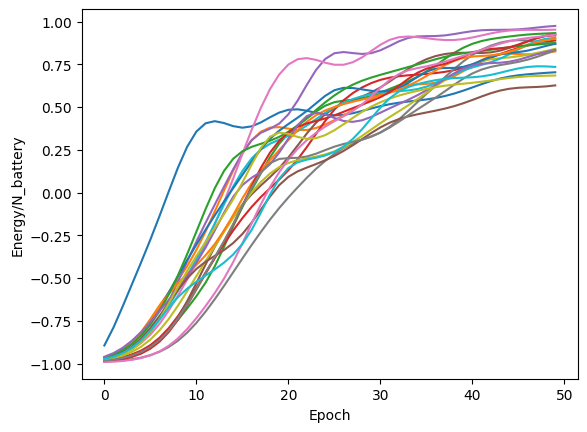

In [101]:
# Plot the cost curves
# plt.plot(train_costs)
plt.plot(range(num_epochs), np.array(cost_list).T)
plt.xlabel("Epoch")
plt.ylabel("Energy/N_battery")
plt.show()

In [102]:
mean_cost = np.mean(cost_list, axis=0)
best_cost = np.max(cost_list, axis=0)

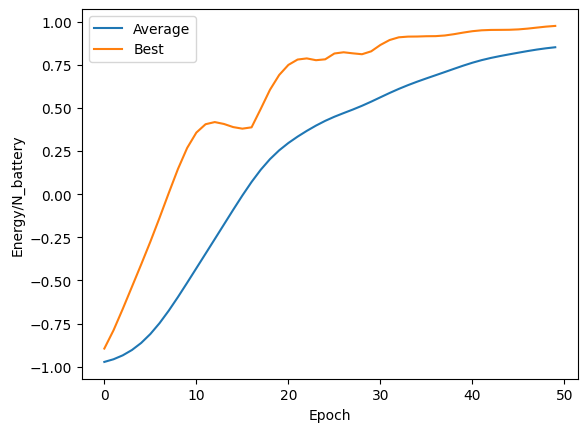

In [103]:
# Plot the cost curves
# plt.plot(train_costs)
plt.plot(mean_cost, label='Average')
plt.plot(best_cost, label='Best')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Energy/N_battery")
plt.show()